In [ ]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 19.7 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 1.7 MB 59.8 MB/s 
     |████████████████████████████████| 5.9 MB 50.6 MB/s 
     |████████████████████████████████| 438 kB 75.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
data = pd.read_csv('spam.csv')
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.groupby('label').aggregate('count')

,text
label,
ham,4825
spam,747


### Imbalance factor

In [ ]:
(len(data[data['label'] == 'spam']) / len(data[data['label'] == 'ham']))*100

15.481865284974095

### Creating a Binary label for Spam

In [ ]:
data['is_spam'] = data['label'].apply(lambda x: 1 if x=='spam' else 0)
data.head()

,label,text,is_spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
data_ham_downsampled = data[data['label'] == 'ham'].sample(data[data['label'] == 'spam'].shape[0])
data_ham_downsampled.shape

(747, 3)

In [ ]:
data_spam = data[data['label'] == 'spam']
data_spam.shape

(747, 3)

### Resampled Data

In [ ]:
data_resampled = pd.concat([data_spam, data_ham_downsampled])
data_resampled.shape

(1494, 3)

In [ ]:
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def sentence_embedding(sentences):
  preprocessed_text = bert_preprocessor(sentences)
  encoded_text = bert_encoder(preprocessed_text)
  return encoded_text['pooled_output']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_resampled['text'], data_resampled['is_spam'], stratify= data_resampled['is_spam'])



In [ ]:
sentence_embedding(["I am an Applied Scientist"])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-8.53814542e-01, -3.51923347e-01, -1.61244690e-01,
         6.27518058e-01,  1.58332214e-01, -3.77079397e-02,
         7.92698264e-01,  1.23102173e-01,  3.17027010e-02,
        -9.99906957e-01, -2.36655660e-02,  7.57012963e-01,
         9.82199371e-01,  1.57362059e-01,  8.91117454e-01,
        -6.17887437e-01, -3.05314325e-02, -5.13239324e-01,
         2.41851240e-01, -4.36399788e-01,  6.02993965e-01,
         9.97012377e-01,  4.47796702e-01,  2.60306448e-01,
         3.30718160e-01,  8.29564154e-01, -5.69637597e-01,
         9.11236882e-01,  9.40909863e-01,  7.05781579e-01,
        -5.91476381e-01,  1.24078989e-01, -9.90299582e-01,
        -6.50027534e-03, -2.47756615e-01, -9.88902807e-01,
         2.94874489e-01, -7.19374180e-01,  1.75654575e-01,
         1.24975085e-01, -8.90012383e-01,  2.59850830e-01,
         9.99480486e-01, -4.66404527e-01,  2.21896037e-01,
        -1.99827373e-01, -9.99978304e-01,  1.44862071e-01,
      

## Model

In [ ]:
# Bert layer

text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'text_input')
preprocessed = bert_preprocessor(text_input)
embed_output = bert_encoder(preprocessed) # 768 dimensional embedding

# Dense layers

layer = tf.keras.layers.Dropout(0.2, name = 'dropout')(embed_output['pooled_output'])
final = tf.keras.layers.Dense(1, activation = 'sigmoid', )(layer)

#Model

model = tf.keras.Model(inputs = [text_input], outputs = [final])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

## Training

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = METRICS
)

In [ ]:
history = model.fit(X_train, y_train, epochs = 15, batch_size = 60)

Epoch 1/15
19/19 [==============================] - 14s 630ms/step - loss: 0.2367 - accuracy: 0.9187 - precision: 0.9121 - recall: 0.9268
Epoch 2/15
19/19 [==============================] - 12s 650ms/step - loss: 0.2373 - accuracy: 0.9179 - precision: 0.9077 - recall: 0.9304
Epoch 3/15
19/19 [==============================] - 12s 649ms/step - loss: 0.2263 - accuracy: 0.9295 - precision: 0.9257 - recall: 0.9339
Epoch 4/15
19/19 [==============================] - 13s 669ms/step - loss: 0.2212 - accuracy: 0.9295 - precision: 0.9287 - recall: 0.9304
Epoch 5/15
19/19 [==============================] - 12s 626ms/step - loss: 0.2239 - accuracy: 0.9295 - precision: 0.9257 - recall: 0.9339
Epoch 6/15
19/19 [==============================] - 12s 623ms/step - loss: 0.2250 - accuracy: 0.9205 - precision: 0.9153 - recall: 0.9268
Epoch 7/15
19/19 [==============================] - 12s 623ms/step - loss: 0.2152 - accuracy: 0.9321 - precision: 0.9246 - recall: 0.9411
Epoch 8/15
19/19 [================

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall'])


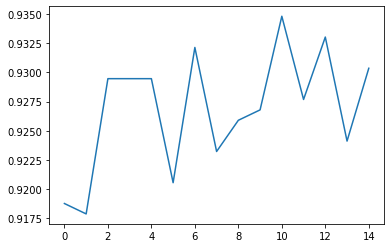

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])


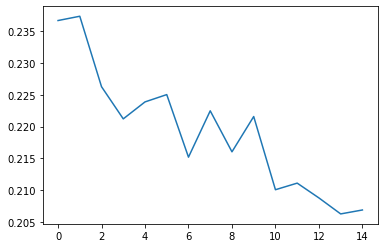

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 326ms/step - loss: 0.1983 - accuracy: 0.9412 - precision: 0.9661 - recall: 0.9144


[0.19832202792167664,
 0.9411764740943909,
 0.9661017060279846,
 0.9144384860992432]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted.shape

12/12 [==============================] - 4s 334ms/step


(374,)

In [ ]:
y_predicted_label = np.where(y_predicted > 0.5, 1, 0)
y_predicted_label

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,

numpy.float32

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm =confusion_matrix(y_test, y_predicted_label)
cr = classification_report(y_test, y_predicted_label)
print(cm, cr)

[[181   6]
 [ 16 171]]               precision    recall  f1-score   support

           0       0.92      0.97      0.94       187
           1       0.97      0.91      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



In [ ]:
emails= ["Win Cash Prize upto 1 Crore, Hurry Up offer valid upto 31st December",
         "I will be an Applied Scientist",
         "India will win World Cup 2022",
         "Buy this Lottery and win cashback upto 1M dollar",
         "Subscribe to our channel to get notifications about our latest newsletter and get updated"]
model.predict(emails)

1/1 [==============================] - 0s 80ms/step


array([[0.6337401 ],
       [0.03973977],
       [0.35604286],
       [0.88010573],
       [0.4051409 ]], dtype=float32)